# Simple powder pattern refinement - nanocrystalline anatase & rutile

This describs a basic single powder pattern refinement using MStruct Python API. It assumes an intial model is saved in an xml-format. One can use e.g. [MStruct GUI](https://github.com/xray-group/mstruct-gui) to create one. It shows how to:
- get calculated pattern
- fix and unfix parameters
- run a simple LSQ refinement
- access parameters, change their values and recalculate the powder pattern
- export data and the final refined model

Last modified: 2024-03-05, Author: Zdenek

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import libMStruct as mst
print(mst.version())

0.15.8-python3.11


### Load data, crystal and microstructure model

The whole MStruct project can loaded from an `*.xml` file.

#### Generating an MStruct xml-file

- If you have `*.imp`, set the number of refinement iteractions to zero and run MStruct binary program. It will produce an `xray.xml`.
- If you have neither `*.imp` or MStruct `*.xml` file, try to use [MStruct GUI](https://github.com/xray-group/mstruct-gui) to create one. ;-) 

Crystal(s) and PowderPattern including data and microstructure model will be loaded in MStruct/ObjCryst global registry after calling `XMLCrystFileLoadAllObject.`

In [4]:
mst.XMLCrystFileLoadAllObject('data/vz1-550-cisty-rnc.xml')

XML: Loading Crystal:
XML: Loading Crystal:AnataseITF(spg:I 41/a m d:2)
Input ScatteringPowerAtom:Ti(Ti4+)
Could not find colour:Ti for ScatteringPower Ti
Input ScatteringPowerAtom:O(O2-)
Could not find colour:O for ScatteringPower O
XML: Loading Atom:Ti1
XML: Loading Atom:O1
XML: finished reading Crystal object:AnataseITF
XML: Loading Crystal:
XML: Loading Crystal:Rutile(spg:P 42/m n m)
Input ScatteringPowerAtom:Ti(Ti4+)
Could not find colour:Ti for ScatteringPower Ti
Input ScatteringPowerAtom:O(O2-)
Could not find colour:O for ScatteringPower O
XML: Loading Atom:Ti1
XML: Loading Atom:O1
XML: finished reading Crystal object:Rutile
->Adding Component :bkgData.vz1-550-cisty.bgr with scale=1
->Adding Component :bkgData_Chebyshev with scale=1
->Adding Component :diffData_Anatase with scale=2.71e-07
->Adding Component :diffData_Rutile with scale=8.57e-08
XML: finished reading Powder Pattern object:pattern0
Finished loading XML
Finished loading XML file:data/vz1-550-cisty-rnc.xml


### Powder pattern

Get a reference to the PowderPattern object from the global RefinableObj registry by calling `GetPowderPattern` function with the PowderPattern object name as its single argument.

In [5]:
pattern = mst.GetPowderPattern('pattern0')

Prepare PowderPattern data for computation, (optionally) fit scale factor and fianlly get a calcuated pattern.

In [6]:
pattern.Prepare()
pattern.FitScaleFactorForRw() # try to comment this line
ycalc = pattern.GetCalc()

### Plotting

We do not have a nice PowderPattern Python wrapper as in ObjCryst so we nned a simple plotting routine. Feel free to customize. :-)

In [7]:
def ms_plot(pattern, xl=(), yl=(), figsize=()):
    if figsize not in [(), None, []]:
        plt.figure(figsize = figsize)

    x = pattern.GetPowderPatternX()
    yobs = pattern.GetPowderPatternObs()
    ycalc = pattern.GetCalc()
    ydiff = yobs - ycalc
    
    lindx = np.ones_like(x, dtype=bool)
    
    if xl not in [(), None, []]:
        plt.xlim(xl)
        lindx = np.logical_and(x>=xl[0]*np.pi/180., x<=xl[1]*np.pi/180.)
    if yl not in [(), None, []]:
        plt.xlim(yl)

    plt.plot(180.0/np.pi *x[lindx], np.sqrt(yobs[lindx]), 'r*', ms=2)
    plt.plot(180.0/np.pi *x[lindx], np.sqrt(ycalc[lindx]), 'b-')
    plt.plot(180.0/np.pi *x[lindx], np.sqrt(np.abs(ydiff[lindx]))*np.sign(ydiff[lindx]), 'g-')
    plt.ylabel('sqrt( Intensity )')
    plt.xlabel('2Theta (deg)');

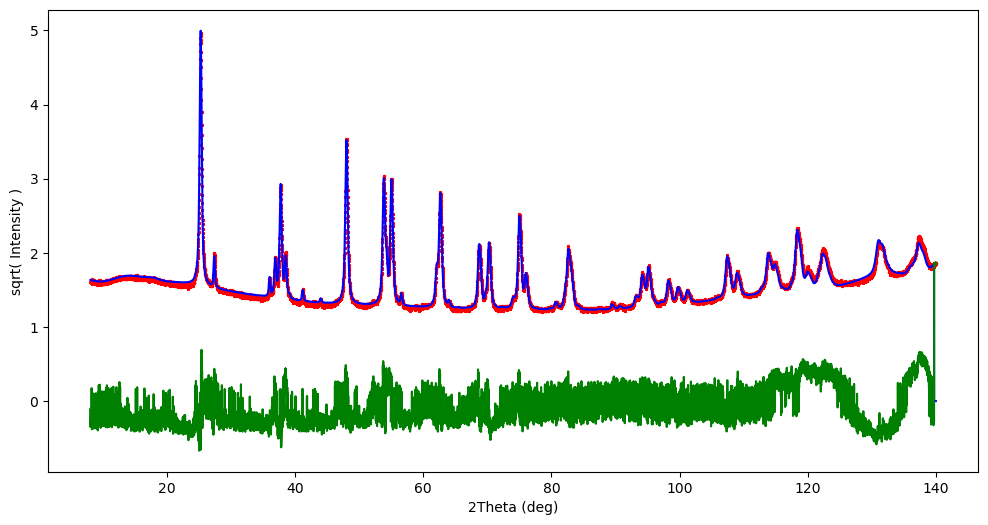

In [8]:
ms_plot(pattern, figsize=(12,6))

Plot a detail.

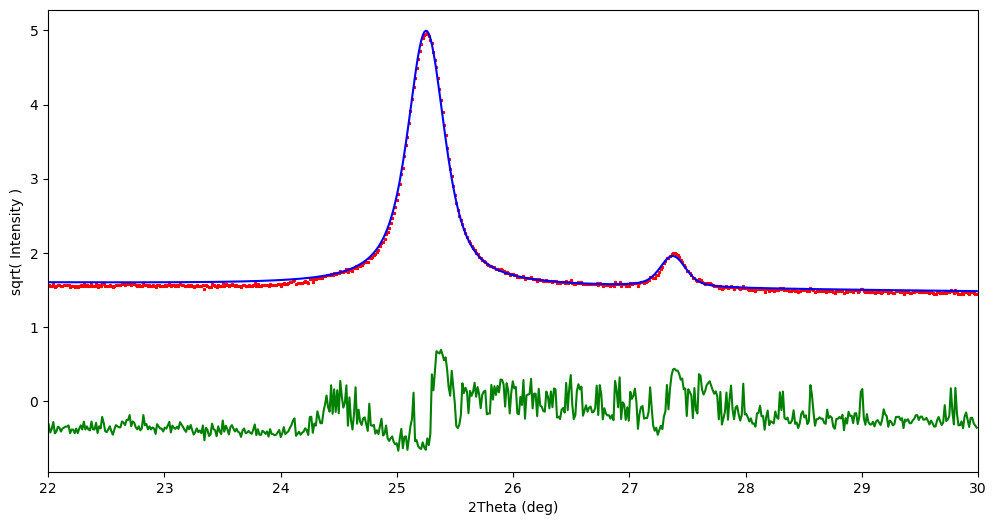

In [11]:
ms_plot(pattern, figsize=(12,6), xl=(22,30))

The peak positions are slightly off.

### Refinement

In [12]:
# Create MStruct & ObjCryst LSQ optimization object for the Powderpattern
# and intialize refinement parameters list. (connect LSQ and pattern together)
lsq = mst.LSQ()

lsq.SetRefinedObj(obj=pattern, LSQFuncIndex=0, init=True, recursive=True)
lsq.AddRefinableObj(obj=pattern) # MStruct LSQ is a compbination of ObjCryst LSQ and ObjCryst Optimization

If we check `pattern` we do not see all refinable parameters.

In [13]:
pattern.Print()

Refinable Object:pattern0, with 7 parameters
#0#Zero:    -0.021056199446 
#1#2ThetaDispl:    -0.044117800891 
#2#2ThetaTransp:     0.000000000000 Fixed
#3#DIFC: 48277.139999999999 Fixed
#4#DIFA:    -6.700000000000 Fixed
#5#Scale_diffData_Anatase:     0.000000270163 
#6#Scale_diffData_Rutile:     0.000000079666 


This is why we have to work with a recursively compiled refinable object provided by LSQ.

In [14]:
lsq.PrepareRefParList(copy_param=False)  # must be called first !
lsqr = lsq.GetCompiledRefinedObj()
lsqr.Print()

Refinable Object:, with 252 parameters
#0#Zero:    -0.021056199446 
#1#2ThetaDispl:    -0.044117800891 
#2#2ThetaTransp:     0.000000000000 Fixed
#3#DIFC: 48277.139999999999 Fixed
#4#DIFA:    -6.700000000000 Fixed
#5#Scale_diffData_Anatase:     0.000000270163 
#6#Scale_diffData_Rutile:     0.000000079666 
#7#Wavelength:     1.541839957237 Fixed
#8#XRayTubeDeltaLambda:     0.003829960013 Fixed
#9#XRayTubeAlpha2Alpha1Ratio:     0.500000000000 Fixed
#10#Background_Point_0:     2.570000000000 Fixed
#11#Background_Point_1:     2.490000000000 Fixed
#12#Background_Point_2:     2.710000000000 Fixed
#13#Background_Point_3:     2.750000000000 Fixed
#14#Background_Point_4:     2.690000000000 Fixed
#15#Background_Point_5:     2.650000000000 Fixed
#16#Background_Point_6:     2.540000000000 Fixed
#17#Background_Point_7:     2.450000000000 Fixed
#18#Background_Point_8:     2.090000000000 Fixed
#19#Background_Point_9:     1.890000000000 Fixed
#20#Background_Point_10:     1.670000000000 Fixed
#21#Backg

### Fix parameter

We can see the *Stress* parameter is zero and not fixed. Let's fix it.

In [17]:
lsq.SetParIsFixed(parName="Stress", fix=True)
# TODO: it does not throw error

Auxilliary function `refine` for fitting ... parameters refinement. It includes everything that we would need to repeat always.

In [19]:
def refine(lsq, nbCycle=-10, silent=False):
    # Refinement
    lsq.PrepareRefParList(copy_param=False)  # must be called first !
    # lsq.GetCompiledRefinedObj().Print()
    lsqr = lsq.GetCompiledRefinedObj()
    lsqr.PrepareForRefinement()
    lsq.Refine(nbCycle=nbCycle, useLevenbergMarquardt=True, silent=silent, # use negative nbCycle to allow refinement stop after convergence
               callBeginEndOptimization=True, minChi2var=0.001) # note: this may take a while

In [20]:
refine(lsq, nbCycle=-20, silent=False)

LSQNumObj::Refine():Beginning 
Refinable Object:, with 252 parameters
#0#Zero:    -0.021056199446 
#1#2ThetaDispl:    -0.044117800891 
#2#2ThetaTransp:     0.000000000000 Fixed
#3#DIFC: 48277.139999999999 Fixed
#4#DIFA:    -6.700000000000 Fixed
#5#Scale_diffData_Anatase:     0.000000270163 
#6#Scale_diffData_Rutile:     0.000000079666 
#7#Wavelength:     1.541839957237 Fixed
#8#XRayTubeDeltaLambda:     0.003829960013 Fixed
#9#XRayTubeAlpha2Alpha1Ratio:     0.500000000000 Fixed
#10#Background_Point_0:     2.570000000000 Fixed
#11#Background_Point_1:     2.490000000000 Fixed
#12#Background_Point_2:     2.710000000000 Fixed
#13#Background_Point_3:     2.750000000000 Fixed
#14#Background_Point_4:     2.690000000000 Fixed
#15#Background_Point_5:     2.650000000000 Fixed
#16#Background_Point_6:     2.540000000000 Fixed
#17#Background_Point_7:     2.450000000000 Fixed
#18#Background_Point_8:     2.090000000000 Fixed
#19#Background_Point_9:     1.890000000000 Fixed
#20#Background_Point_10:    

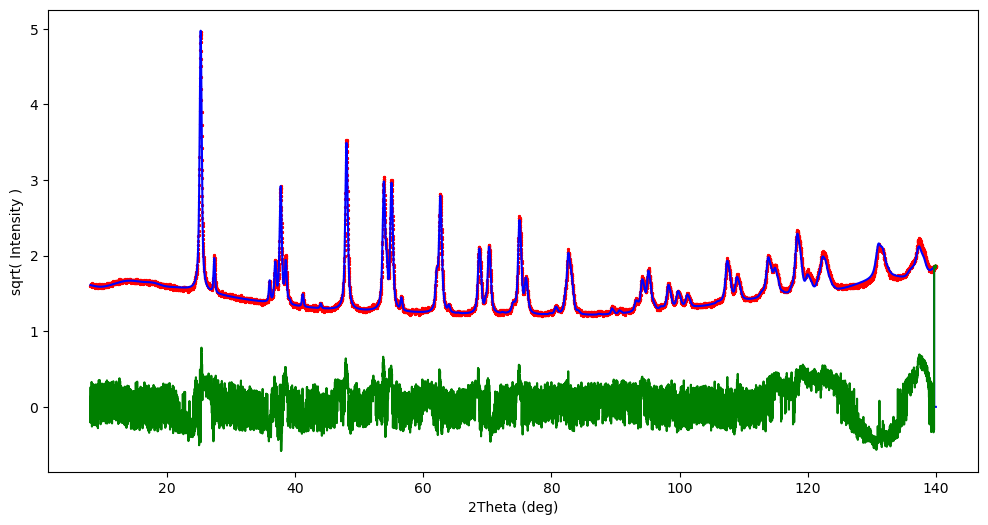

In [22]:
ms_plot(pattern, figsize=(12,6))

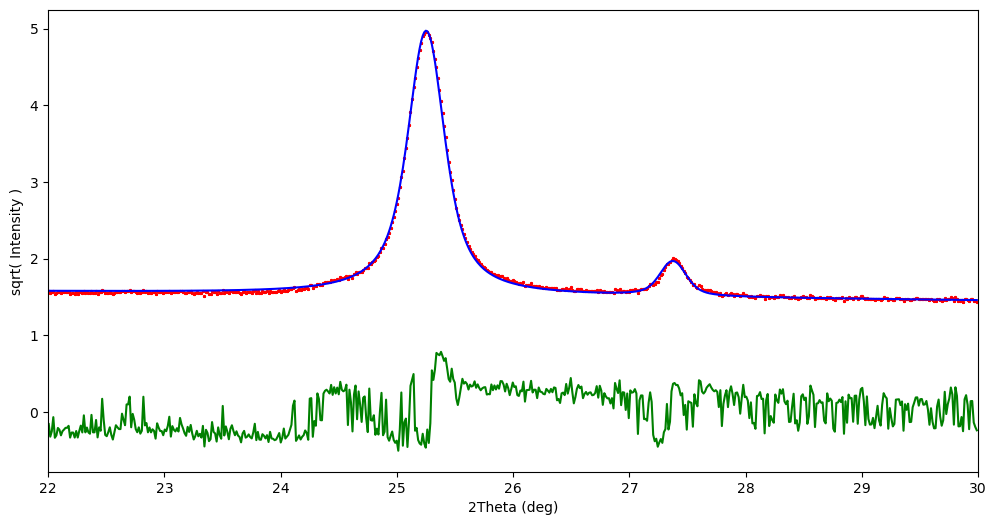

In [24]:
ms_plot(pattern, figsize=(12,6), xl=(22,30))

Let's unfix the *Stress* parameter and refinement again.

Results after last refinement :(18 non-fixed parameters)
R-factor  : 0.0290679
Rw-factor : 0.0294262
Chi-Square: 39282.1
GoF: 1.98098
Variable information : Initial, last cycle , current values and sigma  + dp = (Initial - current value), (dp / initial), (dp / sigma), extended parameter name
Zero                                -0.01946731      -0.01924108      -0.01919646       0.01061962         -0.0002708497     0.00%     2.55%                                                    
2ThetaDispl                         -0.04524300      -0.04545453      -0.04549608       0.01021356          0.0002530857     0.00%     2.48%                                                    
Scale_diffData_Anatase               0.00000027       0.00000027       0.00000027       0.00000000         -0.0000000015     0.55%   108.34%                                                    
Scale_diffData_Rutile                0.00000009       0.00000009       0.00000009       0.00000000         -0.0000000004     0.4

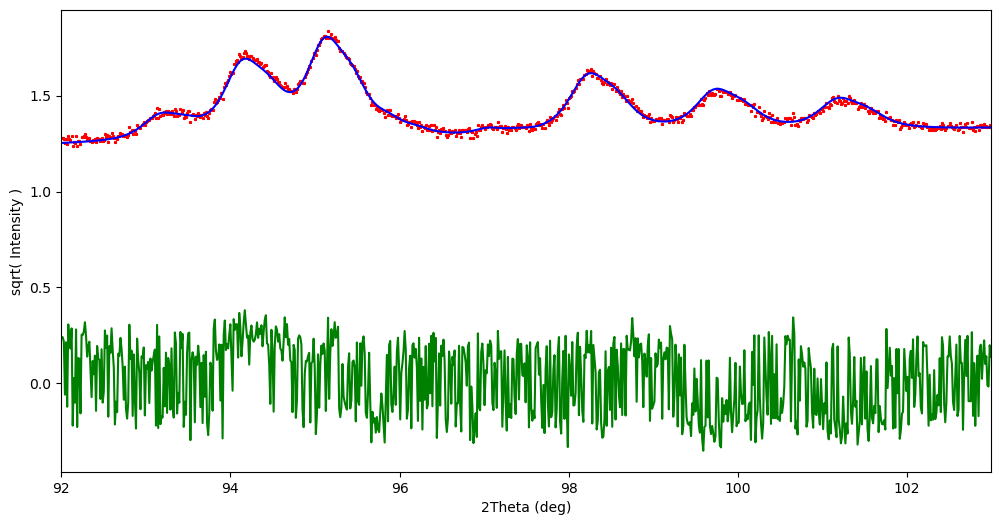

In [25]:
lsq.SetParIsFixed(parName="Stress", fix=False)
refine(lsq, nbCycle=-20, silent=True)
lsq.PrintRefResults()
ms_plot(pattern, figsize=(12,6), xl=(20,32))

So we see the GoF and the peak positions are better.

### Parameter value

In [28]:
name = 'M'
try:
    print('%s = %.2f (nm)' % (name, lsqr.GetPar(name).value,))
except:
    print('it does not work')

LibCryst ++ exception thrown!!
  Message: RefinableObj::FindPar(M): found duplicate refinable variable name in object:
Attempting to save ObjCryst++ environment to file:ObjCryst2024-03-05_14-20-35.xml
it does not work


Let's set it much higher (10x) and see how it affects the powder pattern.

It is visible that mainly the peaks above $2\Theta > 98^\circ$ are sensitive to it.

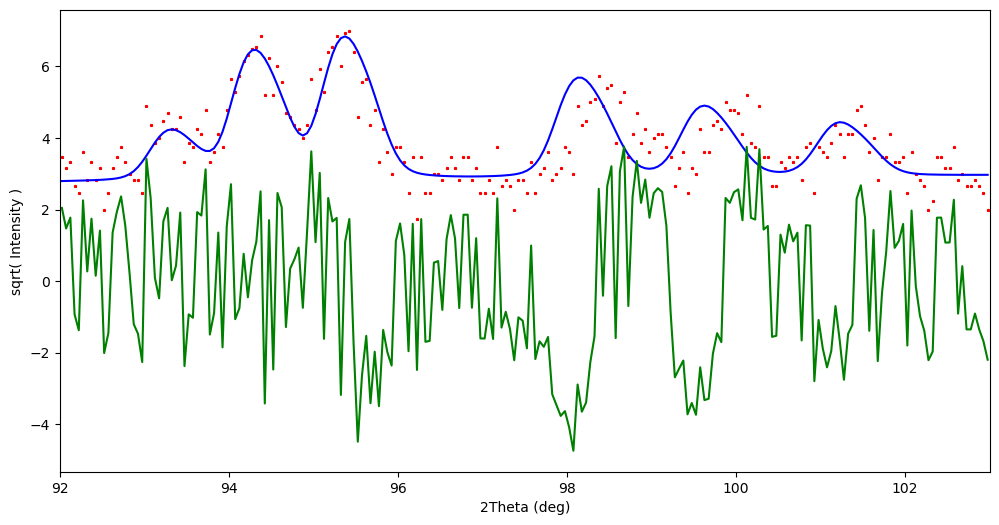

In [19]:
lsqr.GetPar('Stress').value = 3.0 # try positive and engative values
ms_plot(pattern, figsize=(12,6), xl=(92,103))

### Extended prameter name

One can use also a global MStruct function returning parameters from the global MStruct & ObjCryst registry with so called *composed extended parameter name*, e.g. `stressCorrAnatase:Stress`.

In [37]:
name = 'sizeProfAnatase:M'
print('%s = %.2f (Å)' % (name, mst.GetPar(name).value,))

sizeProfAnatase:M = 220.21 (Å)


Let's set it much higher (10x) and see how it affects the powder pattern.

It is visible that mainly the peaks above $2\Theta > 98^\circ$ are sensitive to it.

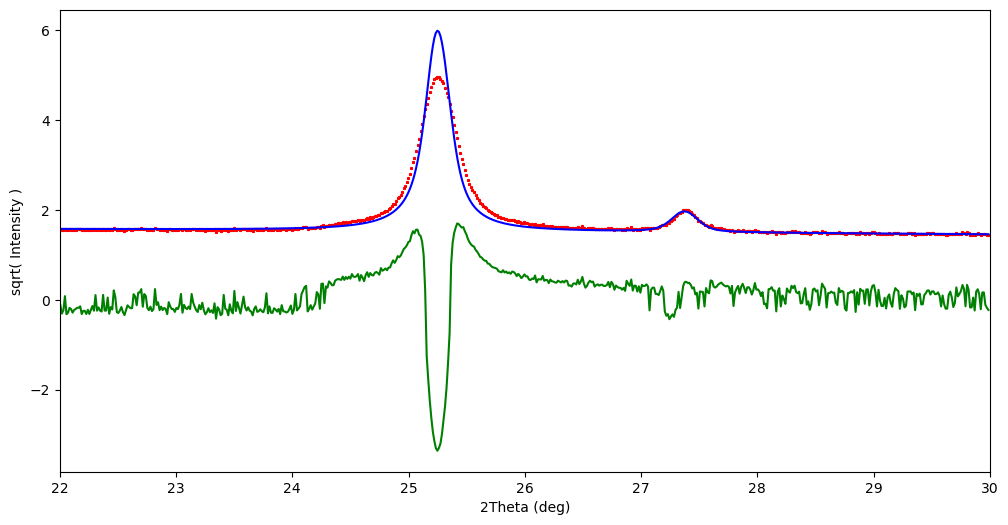

In [41]:
mst.GetPar('sizeProfAnatase:M').value = 400.0 # try increase and decreased the value
ms_plot(pattern, figsize=(12,6), xl=(22,30))

In [43]:
mst.GetPar('sizeProfAnatase:M').value = 200.0

#simple_name = 'Stress'
#print('%s = %.3f (GPa)' % (simple_name, lsqr.GetPar(simple_name).value,))

Refine it again.

In [44]:
refine(lsq, nbCycle=-20, silent=True)
lsq.PrintRefResults()

Results after last refinement :(18 non-fixed parameters)
R-factor  : 0.0290858
Rw-factor : 0.0294273
Chi-Square: 39284.9
GoF: 1.98105
Variable information : Initial, last cycle , current values and sigma  + dp = (Initial - current value), (dp / initial), (dp / sigma), extended parameter name
Zero                                -0.01919646      -0.01691453      -0.01687444       0.01062110         -0.0023220198     0.00%    21.86%                                                    
2ThetaDispl                         -0.04549608      -0.04770283      -0.04774407       0.01021318          0.0022479850     0.00%    22.01%                                                    
Scale_diffData_Anatase               0.00000027       0.00000027       0.00000027       0.00000000          0.0000000000     0.01%     2.57%                                                    
Scale_diffData_Rutile                0.00000009       0.00000009       0.00000009       0.00000000          0.0000000001     0.1

### Saving powder pattern

One can always get the observed and calcuated data as numpy arrays as it is illustrated in the `ms_plot` function.

A native MStruct function `SavePowderPattern` writing data in a multi-column format is available too ... mainly for convenience.

In [22]:
pattern.SavePowderPattern('pattern.dat')

### Saving xml-file

One may like to saved the final model with refined parameters in the MStruct xml-format using the global `XMLCrystFileSaveGlobal` function.

*Note: This will export all MStruct objects loaded and created in this Python session. Even those not explicitely used!*

In [23]:
mst.XMLCrystFileSaveGlobal('final-ex1.xml')